In [2]:
import numpy as np
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import zscore
from ipyparallel import Client
import time

In [3]:
RC = Client()
RC = RC[:]
print (len(RC))

25


In [4]:
base_dir = '/home/parashar/scratch/quadcomb/data/g4_seq/reanalysis'

In [5]:
def set_tick_fs(axis, size=12):
    for xt in axis.xaxis.get_ticklabels():
        xt.set_fontsize(size)
    for yt in axis.yaxis.get_ticklabels():
        yt.set_fontsize(size)
    return True

## Mismatch and quality arrays files for all the reads

In [29]:
read_level_data_dir = base_dir + '/fastq_compare_arrays/Na_PDS_2'
mismatch_files = []
qual_diff_files = []
for d in ['SRR1693711', 'SRR1693712']:
    mismatch_files.extend(sorted(glob.glob("%s/%s/*_mismatches.npy" % (read_level_data_dir, d))))
    qual_diff_files.extend(sorted(glob.glob("%s/%s/*_qual_diffs.npy" % (read_level_data_dir, d))))

len(mismatch_files), len(qual_diff_files)

(342, 342)

## QG intersected alignment BED files

In [9]:
intersect_dir = base_dir + '/qg4_aligned_intersect/Na_PDS_2'
intersect_files = []
for d in ['SRR1693711', 'SRR1693712']:
    intersect_files.extend(glob.glob("%s/%s/*.bed" % (intersect_dir, d)))

(len(intersect_files))

342

In [11]:
def get_closest_dist(fn):
    dist = []
    with open(fn) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            if int(c[4]) > 20:
                dist.append(c[-1])
    return dist

ar = RC.map_async(get_closest_dist, intersect_files)
ar.wait_interactive()
closest_dists = ar.get()
len(closest_dists)

  25/25 tasks finished after   91 s
done


342

Total 304762400 alignemnts with MAPQ > 20
98297247 alignments overlapped Quadgraph coordinates
Those not overlapping are at median distance of 494 nt


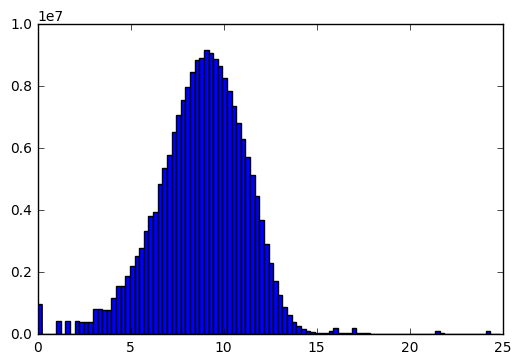

In [12]:
merged_dist = []
for i in closest_dists:
    merged_dist.extend(i)
merged_dist = np.array(merged_dist, dtype=int)
abs_dist = np.abs(merged_dist)

print ("Total %d alignemnts with MAPQ > 20" % abs_dist.shape[0])
print ("%d alignments overlapped Quadgraph coordinates" % len(abs_dist[abs_dist == 0]))
print ("Those not overlapping are at median distance of %d nt" % np.median(abs_dist[abs_dist > 0]))

_ = plt.hist(np.log2(abs_dist[abs_dist != 0]), bins=100)
plt.show()

## Quality difference arrays of reads intersecting with QG and >30 mismatches

In [13]:
qg_og_qualdiff_dir = base_dir + '/og_qg_qual_diff_arrays/Na_PDS_2'
qg_og_qualdiff_files = []
for d in ['SRR1693711', 'SRR1693712']:
    qg_og_qualdiff_files.extend(glob.glob("%s/%s/*_qualdiff_array.npy" % (
                qg_og_qualdiff_dir, d)))

len(qg_og_qualdiff_files)

342

In [14]:
def load_array(fn):
    import numpy as np
    return np.load(fn)

ar = RC.map_async(load_array, qg_og_qualdiff_files)
ar.wait_interactive()

  25/25 tasks finished after  168 s
done


In [15]:
qual_diffs = ar.get()
len(qual_diffs)

342

In [16]:
random_diffs = qual_diffs[0][np.random.randint(0, len(qual_diffs[0]), 100)]
for n, i in enumerate(qual_diffs[1:]):
    print ("\r%d" % n, flush=True, end='')
    rand = i[np.random.randint(0, len(i), 100)]
    random_diffs = np.vstack((random_diffs, rand))
random_diffs.shape

340

(34200, 151)

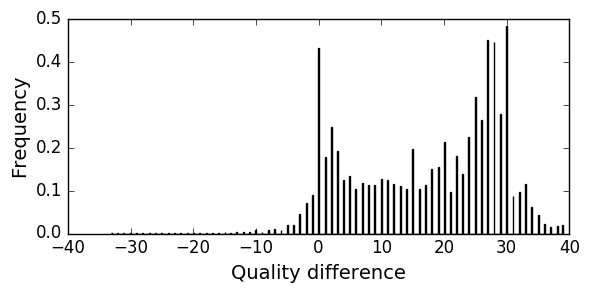

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
ax.hist(random_diffs.flatten(), bins=500, normed=True)
ax.set_xlabel('Quality difference', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
set_tick_fs(ax)
fig.tight_layout()
plt.savefig("qg_og_qualdiffs_histogram_random.png")
plt.show()

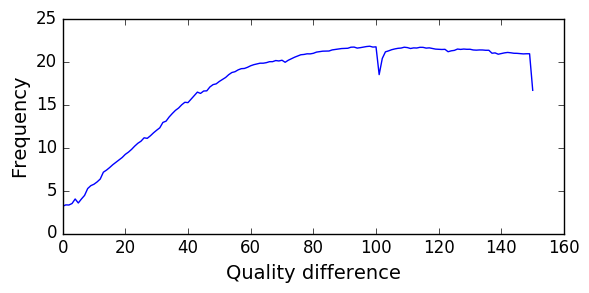

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
ax.plot(random_diffs.mean(axis=0))
ax.set_xlabel('Quality difference', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
set_tick_fs(ax)
fig.tight_layout()
plt.savefig("qg_og_qualdiffs_poswise_random.png")
plt.show()

## Traces array containing files of switch-point bayesian analysis

In [19]:
switchpoint_dir = base_dir + '/switchpoint_arrays/Na_PDS_2'
trace_files = []
for d in ['SRR1693711', 'SRR1693712']:
    trace_files.extend(sorted(glob.glob("%s/%s/*.npy" % (switchpoint_dir, d))))

len(trace_files)

342

In [20]:
def get_trace_median(fn):
    import numpy as np
    t = np.load(fn)
    return np.median(t, axis=2).T

trace_medians = RC.map_sync(get_trace_median, trace_files)

In [25]:
switchpoints = []
early_means = []
late_means = []
for i in trace_medians:
    switchpoints.extend(i[0])
    early_means.extend(i[1])
    late_means.extend(i[2])
switchpoints = np.array(switchpoints)
early_means = np.array(early_means)
late_means = np.array(late_means)

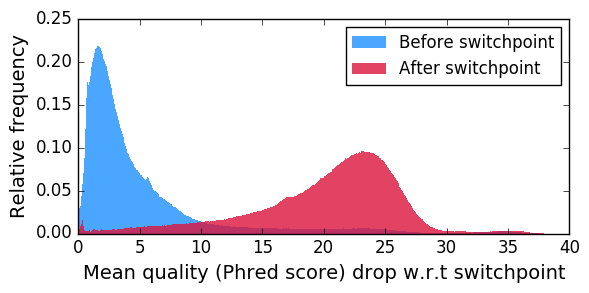

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
ax.hist(early_means, bins=500, color='dodgerblue',
        alpha=0.8, lw=0, normed=True, label='Before switchpoint')
ax.hist(late_means, bins=500, color='crimson',
        alpha=0.8, lw=0, normed=True, label='After switchpoint')
ax.set_xlabel('Mean quality (Phred score) drop w.r.t switchpoint', fontsize=14)
ax.set_ylabel('Relative frequency', fontsize=14)
ax.legend(fontsize=12)
set_tick_fs(ax)
fig.tight_layout()
plt.savefig("switchpoint_quality_drop.png")
plt.show()

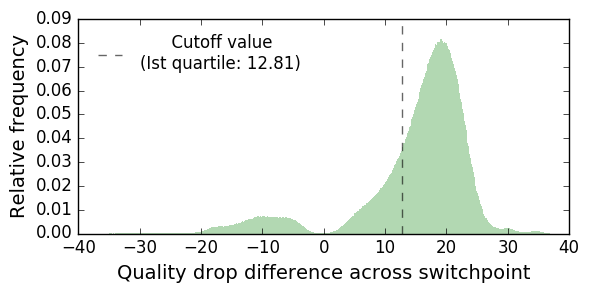

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
diff = late_means - early_means
third_q = np.percentile(diff, 25)
ax.hist(diff, bins=500,
        color='green', alpha=0.3, lw=0, normed=True)
ax.axvline(third_q, lw=1, ls='--', c='k', alpha=0.6,
           label="      Cutoff value\n(Ist quartile: %.2f)" % third_q)
ax.set_xlabel('Quality drop difference across switchpoint', fontsize=14)
ax.set_ylabel('Relative frequency', fontsize=14)
set_tick_fs(ax)
ax.legend(loc='upper left', fontsize=12, frameon=False)
fig.tight_layout()
plt.savefig("switchpoint_difference.png")
plt.show()

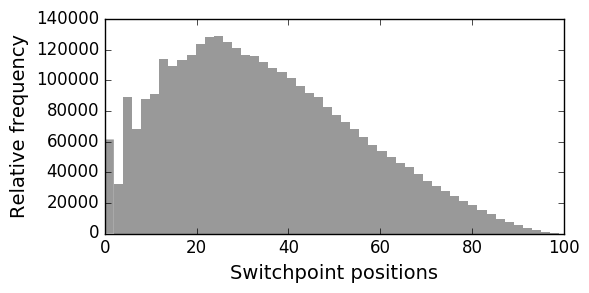

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
ax.hist(switchpoints[diff > third_q], bins=50,
        color='grey', alpha=0.8, lw=0)
ax.set_xlabel('Switchpoint positions', fontsize=14)
ax.set_ylabel('Relative frequency', fontsize=14)
set_tick_fs(ax)
fig.tight_layout()
plt.savefig("switchpoint_positions.png")
plt.show()